<a href="https://colab.research.google.com/github/skmisht/CNN/blob/main/CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Melanoma detection - PyTorch 

In [ ]:
import os
import csv 
import zipfile
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from google.colab import files
import torch
print("Current Torch version: ", torch.__version__)
# to install if there is no latest version of torch
# !pip install -q torch==1.0.0 

import torchvision
from torchvision.transforms import transforms

Current Torch version:  1.7.0+cu101


In [ ]:
# test if the notebook is running on GPU
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
# accessing data files from shared directory 
import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
os.chdir("/content/drive/My Drive/isic-challenge-2017")

Mounted at /content/drive


In [ ]:
# list of files in isic-challenge folder
base_dir = '/content/drive/My Drive/isic-challenge-2017'
for file in os.listdir(base_dir):
  if os.path.isdir(os.path.join(base_dir, file)) or os.path.isfile(os.path.join(base_dir, file)):
    print(file)

ISIC-2017_Training_Part3_GroundTruth.csv
ISIC-2017_Validation_Part3_GroundTruth.csv
ISIC-2017_Test_v2_Part3_GroundTruth.csv
ISIC-2017_Test_v2_Data
ISIC-2017_Training_Data
ISIC-2017_Validation_Data


In [ ]:
# Training Images
training_images = '/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data'
# first 10 images from training
training_images_names = os.listdir(training_images)
print(training_images_names[:10])
# training ground truth data
training_groundTruth_csv = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Part3_GroundTruth.csv')
print(training_groundTruth_csv.head(5))

print() # blank line

# Testing images 
testing_images = '/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data'
testing_images_names = os.listdir(testing_images)
print(testing_images_names[:10])
# testing ground truth data
test_groundTruth_csv = pd.read_csv('/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv')
print(test_groundTruth_csv.head(5))


print() # blank line

# Meta csv files from training & testing
training_meta_file = '/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data/ISIC-2017_Training_Data_metadata.csv'
testing_meta_file = '/content/drive/MyDrive/isic-challenge-2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_metadata.csv' 
# display training meta data 
train_meta = pd.read_csv(training_meta_file, delimiter=',')
train_meta.head()

print() # blank line

# display the test meta data
test_meta = pd.read_csv(testing_meta_file, delimiter=',')
test_meta.head()


['ISIC_0013474.jpg', 'ISIC_0013474_superpixels.png', 'ISIC_0013480.jpg', 'ISIC_0013480_superpixels.png', 'ISIC_0013490_superpixels.png', 'ISIC_0013492_superpixels.png', 'ISIC_0013486.jpg', 'ISIC_0013489.jpg', 'ISIC_0013486_superpixels.png', 'ISIC_0013487.jpg']
       image_id  melanoma  seborrheic_keratosis
0  ISIC_0000000       0.0                   0.0
1  ISIC_0000001       0.0                   0.0
2  ISIC_0000002       1.0                   0.0
3  ISIC_0000003       0.0                   0.0
4  ISIC_0000004       1.0                   0.0

['ISIC_0013414.jpg', 'ISIC_0013414_superpixels.png', 'ISIC_0013455_superpixels.png', 'ISIC_0013416.jpg', 'ISIC_0013455.jpg', 'ISIC_0013416_superpixels.png', 'ISIC_0013457_superpixels.png', 'ISIC_0013457.jpg', 'ISIC_0013459.jpg', 'ISIC_0013465_superpixels.png']
       image_id  melanoma  seborrheic_keratosis
0  ISIC_0012086       0.0                   1.0
1  ISIC_0012092       0.0                   0.0
2  ISIC_0012095       0.0                   0

,image_id,age_approximate,sex
0,ISIC_0012086,30,male
1,ISIC_0012092,40,male
2,ISIC_0012095,25,male
3,ISIC_0012134,75,female
4,ISIC_0012136,70,male


In [ ]:
# total images in training and testing directory
print("Total images in Training: ", len(training_images_names))
print("Total images in Testing: ", len(testing_images_names))

Total images in Training:  4001
Total images in Testing:  1201


In [ ]:
# unique id from train csv
print(f"Image Ids from Training csv: \nTotal patient ids are: {train_meta['image_id'].count()},\nThe unique ids are: {train_meta['image_id'].value_counts().shape[0]}")
print() # blank line
print(f"Image Ids from Testing csv: \nTotal patient ids are: {test_meta['image_id'].count()},\nThe unique ids are: {test_meta['image_id'].value_counts().shape[0]}")

Image Ids from Training csv: 
Total patient ids are: 2000,
The unique ids are: 2000

Image Ids from Testing csv: 
Total patient ids are: 600,
The unique ids are: 600


# Training Data 
  - merging training ground truth csv and meta csv
  - adding the image names to the training data

In [ ]:
# Inner join - joining training ground truth and meta csv 
training_data = pd.merge(training_groundTruth_csv, train_meta, on = 'image_id')
training_data.head(5)

,image_id,melanoma,seborrheic_keratosis,age_approximate,sex
0,ISIC_0000000,0.0,0.0,55,female
1,ISIC_0000001,0.0,0.0,30,female
2,ISIC_0000002,1.0,0.0,60,female
3,ISIC_0000003,0.0,0.0,30,male
4,ISIC_0000004,1.0,0.0,80,male


In [ ]:
# empty list for the all the .jpg file from training images
training_images_names_list = list()
# iterate over each image file
for file in os.listdir(training_images):
  if file.endswith(".jpg"):
    training_images_names_list.append(file)
    
# display the list
print(training_images_names_list[:10])

print() # blank line

# adding the images files to the training data
training_data['image_name'] = training_data['image_id'] + '.jpg'
training_data.head()

['ISIC_0013474.jpg', 'ISIC_0013480.jpg', 'ISIC_0013486.jpg', 'ISIC_0013489.jpg', 'ISIC_0013487.jpg', 'ISIC_0013492.jpg', 'ISIC_0013488.jpg', 'ISIC_0013490.jpg', 'ISIC_0013495.jpg', 'ISIC_0013493.jpg']



,image_id,melanoma,seborrheic_keratosis,age_approximate,sex,image_name
0,ISIC_0000000,0.0,0.0,55,female,ISIC_0000000.jpg
1,ISIC_0000001,0.0,0.0,30,female,ISIC_0000001.jpg
2,ISIC_0000002,1.0,0.0,60,female,ISIC_0000002.jpg
3,ISIC_0000003,0.0,0.0,30,male,ISIC_0000003.jpg
4,ISIC_0000004,1.0,0.0,80,male,ISIC_0000004.jpg


# Test Data
  - merging testing ground truth csv and meta csv
  - adding the image names to the testing data

In [ ]:
# Inner join - joining test ground truth and meta csv 
test_data = pd.merge(test_groundTruth_csv, test_meta, on = 'image_id')
test_data.head(5)

,image_id,melanoma,seborrheic_keratosis,age_approximate,sex
0,ISIC_0012086,0.0,1.0,30,male
1,ISIC_0012092,0.0,0.0,40,male
2,ISIC_0012095,0.0,0.0,25,male
3,ISIC_0012134,0.0,1.0,75,female
4,ISIC_0012136,0.0,1.0,70,male


In [ ]:
# empty list for the all the .jpg file from test images
test_images_names_list = list()
# iterate over each image file 
for file in os.listdir(testing_images):
  if file.endswith(".jpg"):
    test_images_names_list.append(file)
# display the list
print(test_images_names_list[:10])

print() # blank line

# adding the image names to the test data 
test_data['image_name'] = test_data['image_id'] + ".jpg"
test_data.head(5)

['ISIC_0013414.jpg', 'ISIC_0013416.jpg', 'ISIC_0013455.jpg', 'ISIC_0013457.jpg', 'ISIC_0013459.jpg', 'ISIC_0013465.jpg', 'ISIC_0013473.jpg', 'ISIC_0013472.jpg', 'ISIC_0013511.jpg', 'ISIC_0013529.jpg']



,image_id,melanoma,seborrheic_keratosis,age_approximate,sex,image_name
0,ISIC_0012086,0.0,1.0,30,male,ISIC_0012086.jpg
1,ISIC_0012092,0.0,0.0,40,male,ISIC_0012092.jpg
2,ISIC_0012095,0.0,0.0,25,male,ISIC_0012095.jpg
3,ISIC_0012134,0.0,1.0,75,female,ISIC_0012134.jpg
4,ISIC_0012136,0.0,1.0,70,male,ISIC_0012136.jpg


# Peek at the some of images from training and test data

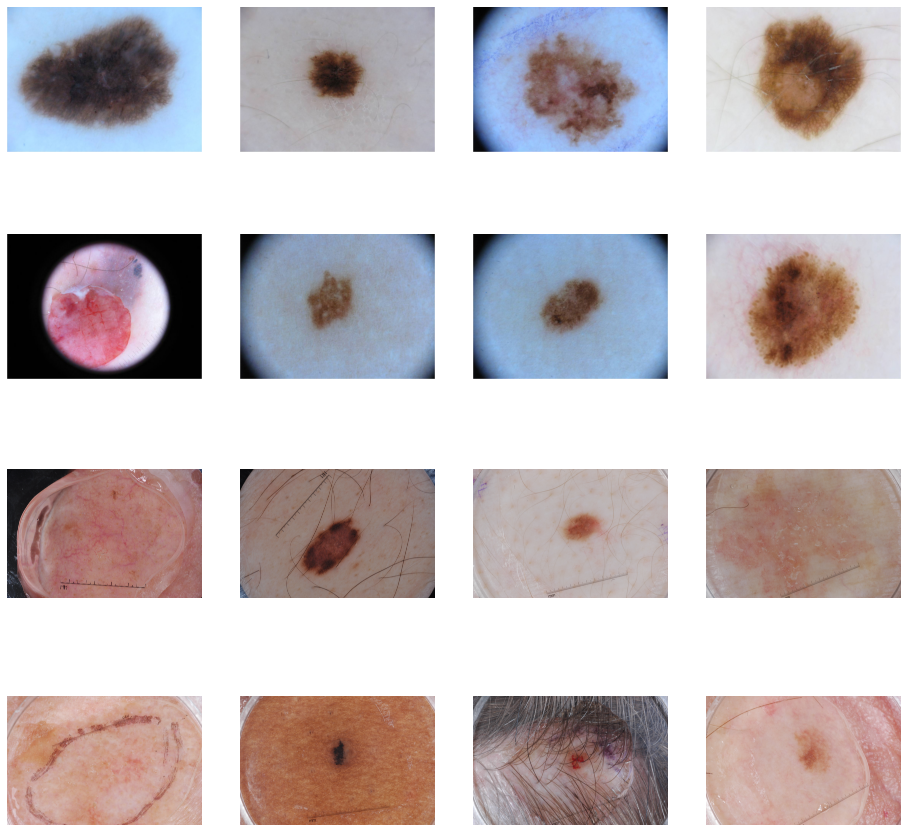

In [ ]:
# Parameter of our graph: we will print output image in a 4*4 configuration
nrows, ncols = 4, 4
# index for iterating over images
pic_index=0

# Display a batch of 8 training and 8 test images, also we can rerun the cell to see a fresh batch at each time
# set up matplotlib fig, and size to fit our 4*4 images
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

# increment the pic_index upto 8
pic_index += 8

# listing images from training and and test data
training_list_of_images = training_data['image_name'].to_list()
test_list_of_images = test_data['image_name'].to_list()

# iterate over the training and test images
train_melanoma_image = [os.path.join(training_images, name) for name in training_list_of_images[pic_index-8:pic_index]]
test_melanoma_image = [os.path.join(testing_images, name) for name in test_list_of_images[pic_index-8:pic_index]]

# enumerting over the train and test images
for i, image_path in enumerate(train_melanoma_image + test_melanoma_image):
  # set up the subplot - subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  # do not display axis or gridline
  sp.axis('off')
  img = mpimg.imread(image_path)
  plt.imshow(img)

# display images
plt.show()

# Data preprocessing steps
  - Training set
      - Train Images 
      - Train targets (Melanoma class)
  - Test set
      - Test Images
      - Test targets (Melanoma class)

In [ ]:
from torchvision import datasets
import torchvision.transforms import transforms
from torch.util.data import DataLoader

# preprocessing steps - training set
